# 03 - Model Training

**Purpose**: Train models, compare, save best one.

**Inputs**: `data/processed/features_v1_*.csv`

**Outputs**: `models/model_v1.joblib`

⚠️ **MEDICAL**: We prioritize RECALL - missing a recurrence is FATAL.

In [10]:
"""
03_model_training.ipynb
Entrenament de models per predicció de recidiva en càncer d'endometri.
Focus: Maximitzar SENSIBILITAT (Recall) - Un Fals Negatiu és fatal!
"""

import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    recall_score, precision_score, f1_score, make_scorer
)

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️ XGBoost no instal·lat. Executa: pip install xgboost")
    XGBOOST_AVAILABLE = False

# SMOTE per balanceig
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    SMOTE_AVAILABLE = True
except ImportError:
    print("⚠️ imbalanced-learn no instal·lat. Executa: pip install imbalanced-learn")
    SMOTE_AVAILABLE = False

# Constants
RANDOM_STATE = 42
PROCESSED_DATA_PATH = '../data/processed/dataset_procesado.csv'
MODELS_PATH = '../models/'

⚠️ imbalanced-learn no instal·lat. Executa: pip install imbalanced-learn


In [11]:
# Càrrega del dataset processat
df = pd.read_csv(PROCESSED_DATA_PATH)

# Separar X i y
X = df.drop(columns=['recidiva'])
y = df['recidiva']

print(f"📊 Dataset shape: {X.shape}")
print(f"\n🎯 Distribució del target:")
print(y.value_counts())
print(f"\n⚠️ Ratio desbalanceig: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

📊 Dataset shape: (154, 7)

🎯 Distribució del target:
recidiva
0    125
1     29
Name: count, dtype: int64

⚠️ Ratio desbalanceig: 4.31:1


In [12]:
# Split estratificat per mantenir proporció del target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y  # Crític per datasets desbalancejats
)

print(f"Train: {X_train.shape[0]} mostres")
print(f"Test: {X_test.shape[0]} mostres")
print(f"\nDistribució train: {y_train.value_counts().to_dict()}")
print(f"Distribució test: {y_test.value_counts().to_dict()}")

Train: 123 mostres
Test: 31 mostres

Distribució train: {0: 100, 1: 23}
Distribució test: {0: 25, 1: 6}


In [13]:
# Escalar features (important per Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler
import os
os.makedirs(MODELS_PATH, exist_ok=True)
joblib.dump(scaler, f'{MODELS_PATH}scaler_v1.joblib')
print(f"✅ Scaler guardat a: {MODELS_PATH}scaler_v1.joblib")

✅ Scaler guardat a: ../models/scaler_v1.joblib


In [14]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Avaluació amb focus mèdic: prioritzem SENSIBILITAT (Recall).
    Un Fals Negatiu (no detectar recidiva) és pitjor que un Fals Positiu.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print(f"\n{'='*60}")
    print(f"📋 RESULTATS: {model_name}")
    print(f"{'='*60}")
    
    # Mètriques
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n🎯 SENSIBILITAT (Recall): {recall:.3f}  ← PRIORITAT MÀXIMA")
    print(f"📊 Precisió: {precision:.3f}")
    print(f"⚖️ F1-Score: {f1:.3f}")
    
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"📈 ROC-AUC: {auc:.3f}")
    
    # Matriu de confusió
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n📊 Matriu de Confusió:")
    print(f"   TN={cm[0,0]}  FP={cm[0,1]}")
    print(f"   FN={cm[1,0]}  TP={cm[1,1]}")
    
    # Interpretació mèdica
    fn = cm[1,0]
    if fn > 0:
        print(f"\n⚠️ ALERTA: {fn} Falsos Negatius (pacients amb recidiva no detectada)")
    else:
        print(f"\n✅ Cap Fals Negatiu!")
    
    print(f"\n{classification_report(y_test, y_pred, target_names=['No Recidiva', 'Recidiva'])}")
    
    return {'recall': recall, 'precision': precision, 'f1': f1, 'model': model}

In [15]:
# Logistic Regression amb class_weight per compensar desbalanceig
log_reg = LogisticRegression(
    class_weight='balanced',  # Ajusta pesos automàticament
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='lbfgs'
)

log_reg.fit(X_train_scaled, y_train)
results_lr = evaluate_model(log_reg, X_test_scaled, y_test, "Logistic Regression")


📋 RESULTATS: Logistic Regression

🎯 SENSIBILITAT (Recall): 0.667  ← PRIORITAT MÀXIMA
📊 Precisió: 0.800
⚖️ F1-Score: 0.727
📈 ROC-AUC: 0.980

📊 Matriu de Confusió:
   TN=24  FP=1
   FN=2  TP=4

⚠️ ALERTA: 2 Falsos Negatius (pacients amb recidiva no detectada)

              precision    recall  f1-score   support

 No Recidiva       0.92      0.96      0.94        25
    Recidiva       0.80      0.67      0.73         6

    accuracy                           0.90        31
   macro avg       0.86      0.81      0.83        31
weighted avg       0.90      0.90      0.90        31



In [16]:
# Random Forest amb class_weight
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Important!
    max_depth=5,              # Evitar overfitting (poques mostres)
    min_samples_leaf=5,       # Regularització
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)  # RF no necessita escalat
results_rf = evaluate_model(rf_model, X_test, y_test, "Random Forest")


📋 RESULTATS: Random Forest

🎯 SENSIBILITAT (Recall): 0.833  ← PRIORITAT MÀXIMA
📊 Precisió: 0.833
⚖️ F1-Score: 0.833
📈 ROC-AUC: 0.980

📊 Matriu de Confusió:
   TN=24  FP=1
   FN=1  TP=5

⚠️ ALERTA: 1 Falsos Negatius (pacients amb recidiva no detectada)

              precision    recall  f1-score   support

 No Recidiva       0.96      0.96      0.96        25
    Recidiva       0.83      0.83      0.83         6

    accuracy                           0.94        31
   macro avg       0.90      0.90      0.90        31
weighted avg       0.94      0.94      0.94        31



In [17]:
if XGBOOST_AVAILABLE:
    # Calcular scale_pos_weight per desbalanceig
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    
    xgb_model = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,  # Compensa desbalanceig
        max_depth=3,                         # Evitar overfitting
        learning_rate=0.1,
        n_estimators=100,
        min_child_weight=5,                  # Regularització
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    xgb_model.fit(X_train, y_train)
    results_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
else:
    print("⚠️ XGBoost no disponible")
    results_xgb = None


📋 RESULTATS: XGBoost

🎯 SENSIBILITAT (Recall): 0.667  ← PRIORITAT MÀXIMA
📊 Precisió: 0.800
⚖️ F1-Score: 0.727
📈 ROC-AUC: 0.953

📊 Matriu de Confusió:
   TN=24  FP=1
   FN=2  TP=4

⚠️ ALERTA: 2 Falsos Negatius (pacients amb recidiva no detectada)

              precision    recall  f1-score   support

 No Recidiva       0.92      0.96      0.94        25
    Recidiva       0.80      0.67      0.73         6

    accuracy                           0.90        31
   macro avg       0.86      0.81      0.83        31
weighted avg       0.90      0.90      0.90        31



In [18]:
# Comparar models per Recall (prioritat mèdica)
print("\n" + "="*60)
print("🏆 COMPARACIÓ FINAL (Ordenat per RECALL)")
print("="*60)

results = [
    ("Logistic Regression", results_lr),
    ("Random Forest", results_rf),
]
if results_xgb:
    results.append(("XGBoost", results_xgb))

# Ordenar per recall (descendent)
results_sorted = sorted(results, key=lambda x: x[1]['recall'], reverse=True)

for i, (name, res) in enumerate(results_sorted):
    emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
    print(f"{emoji} {name}: Recall={res['recall']:.3f}, F1={res['f1']:.3f}")

# Seleccionar millor model
best_name, best_result = results_sorted[0]
best_model = best_result['model']
print(f"\n✅ Millor model seleccionat: {best_name}")


🏆 COMPARACIÓ FINAL (Ordenat per RECALL)
🥇 Random Forest: Recall=0.833, F1=0.833
🥈 Logistic Regression: Recall=0.667, F1=0.727
🥉 XGBoost: Recall=0.667, F1=0.727

✅ Millor model seleccionat: Random Forest


In [19]:
# Guardar el millor model
model_filename = f'{MODELS_PATH}model_v1.joblib'
joblib.dump(best_model, model_filename)
print(f"✅ Model guardat a: {model_filename}")

# Guardar feature names per l'app
feature_names = list(X.columns)
joblib.dump(feature_names, f'{MODELS_PATH}feature_names_v1.joblib')
print(f"✅ Feature names guardats")

print(f"\n📋 Features utilitzades:")
for i, feat in enumerate(feature_names, 1):
    print(f"   {i}. {feat}")

✅ Model guardat a: ../models/model_v1.joblib
✅ Feature names guardats

📋 Features utilitzades:
   1. FIGO2023
   2. recep_est_porcent
   3. afectacion_linf
   4. grado_histologi
   5. Reseccion_macroscopica_complet
   6. edad
   7. imc


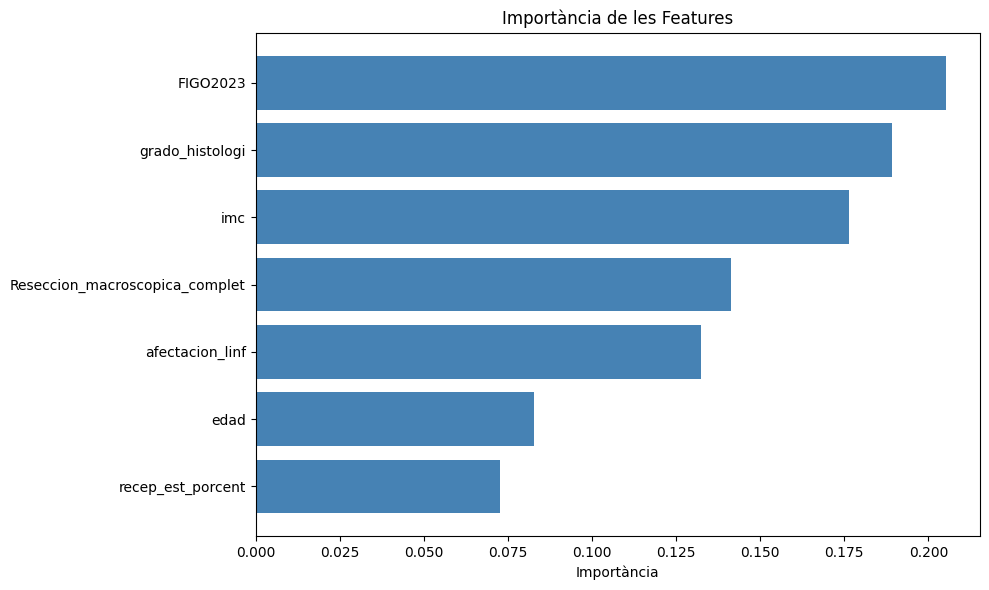

In [20]:
import matplotlib.pyplot as plt

# Feature importance del Random Forest
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importances = np.abs(best_model.coef_[0])
else:
    importances = None

if importances is not None:
    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp['feature'], feat_imp['importance'], color='steelblue')
    plt.xlabel('Importància')
    plt.title('Importància de les Features')
    plt.tight_layout()
    plt.show()

## Next Step
→ Go to `04_model_evaluation.ipynb`